# PLOT maps and make movies of DREAM model output (some examples)
* Purpose: demonstrate how to read some DREAM model output (here temperature at 500 hPa, T31 resolution) and plot timeseries, maps for a series of time steps (and make a movie out of them).
* stephanie leroux 
* last update: 28/03/19

========================================================================================================================

### How to use this notebook:
- First you can browse and read it online on github (that's probably what you're doing right now!).
- Download the repository on your local machine by running git: ```git clone https://github.com/dream-gcm/dream-tools.git``` 
- Then on your local machine:
    * You can read and execute each of the code cells of this notebook from a jupyter interface (in short, it's an iterface to interactively use/run/plot python). So if you have installed python from the anaconda distribution, the jupyter interface is installed with the distrib. From a termninal, just run ```jupyter lab``` and a jupyter window will open in your browser, from which you can open this notebook on your local machine (click on the left of the window). When it's open, you can execute each of the cells locally on your machine. And of course, don't forget to edit the line ```diri = "/Users/leroux/DATA/DREAM_DATA/T31/"``` so that it links to the model output files you have on your local machine.
    * If you only have python but not the jupyter interface, you can use any bits of the code showed in this notebook in a normal python script run in the terminal.  I'm providing an example script in this repository that loop of all timesteps of the data and plot a map from each timestep. Run in the terminal: ```python demo_plot_all_maps.py ```.




### Technical notes:
* This is Python 3
* Module requirements for this notebook:
    * numpy
    * xarray
    * cartopy
    * matplotlib
    * note that the notebook also import a custom library ```utils_SLX_plots ``` that you
    ll also find in this repository.
* More docs: 
    - software carpentry python
    - xarray
    - software carpentry git


========================================================================================================================

# Imports

In [1]:
## standart libraries
import os,sys
import numpy as np

# xarray
import xarray as xr
    
# plot
import cartopy.crs as ccrs
import cartopy.feature as ccf
import cartopy.util as ccu
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

# My custom module with plot tools
import utils_SLX_plots_dream as slx


# Only if using jupyter notebook. Otherwise, comment out.
%matplotlib inline 

=====================================================================================================

# Read DREAM model output:

* Set parameters:

In [2]:
### local directory of input files (on my laptop)
diri = "/Users/leroux/DATA/DREAM_DATA/T31/"

# name of the config exp.
CONFIGNAME = "history.air.500.model.4xdaily"

# input file
fili = CONFIGNAME+".nc"

* Read data (with xarray):

In [3]:
#read all temperature data from file
air = xr.open_dataset(diri+fili,decode_times=True)['air'].squeeze()
# note: .squeeze() is used to get rid of the spurious dimensions (i.e. here, level)


# print info on the array
print(air)


<xarray.DataArray 'air' (time: 81, lat: 48, lon: 96)>
[373248 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 -72.36 -68.65 -64.94 ...
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 18.75 22.5 26.25 30.0 ...
    lev      float64 0.5
  * time     (time) datetime64[ns] 1979-01-01 1979-01-01T06:00:00 ...
Attributes:
    units:          degC
    long_name:      air temperature on sigma levels
    standard_name:  temperature


* Print max, min, mean values of all array

In [4]:
print(air.max())
print(air.mean())
print(air.min())

<xarray.DataArray 'air' ()>
array(12.30720425916661)
Coordinates:
    lev      float64 0.5
<xarray.DataArray 'air' ()>
array(0.49459222001254666)
Coordinates:
    lev      float64 0.5
<xarray.DataArray 'air' ()>
array(-6.325698451959397)
Coordinates:
    lev      float64 0.5


=====================================================================================================


# Examples of how to select subset of data and make quick and dirty plots (no projection, no continents, etc):


## 1. Select one time step and plot (quick and dirty):

- Here you select data with a time __index__ (```it``` is an integer):
        

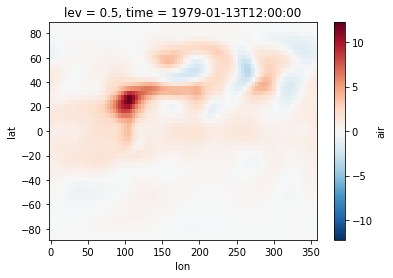

In [5]:
# time index at which select data
it = 50

# select data
datasubset1 = air.isel(time=it)

# plot (quick and dirty first look)
datasubset1.plot()

* Here you select data with a time __coordinate__ (```cdate``` is a calendar date):

_Note that in that case, we use the function ```.sel()``` (while it was ```.isel()``` above when using an index.)_

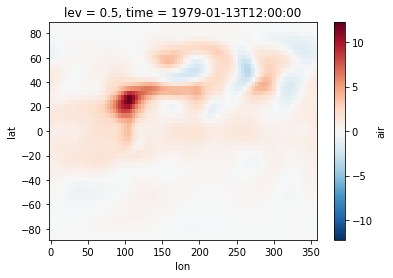

In [6]:
# time index at which select data
cdate = '1979-01-13T12:00:00'

# select data
datasubset2 = air.sel(time=cdate)

# plot (quick and dirty first look)
datasubset2.plot()

_Note: to plot nicer and more customed maps, see below._


## 2. Select all timesteps at one grid point and plot timeseries (quick and dirty)


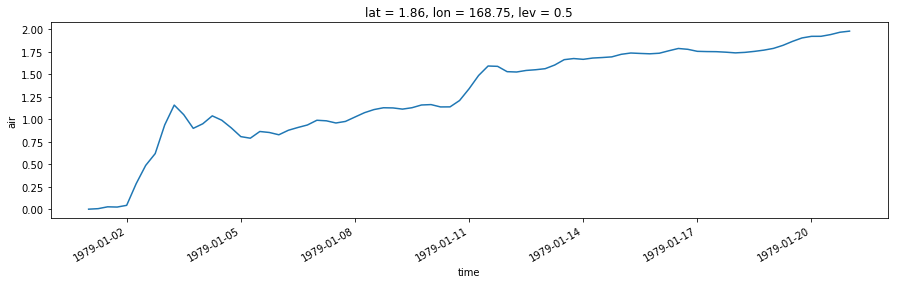

In [7]:
# select data
datasubset3 = air.sel(lat=3.,lon=170.,method='nearest')

# plot
fig1 = plt.figure(figsize=([15,4]),facecolor='white')        
datasubset3.plot()
plt.show()

=====================================================================================================
# - Plot a set of maps:

* Now the code below is a bit  more complex than above. It loops on all the timesteps and plot a map each timestep (or could also be one map every day  or anything else). It uses a plot routine that i have written, called with ```cs = slx.plotmap(...)``` where ```(...)``` are the plot options.


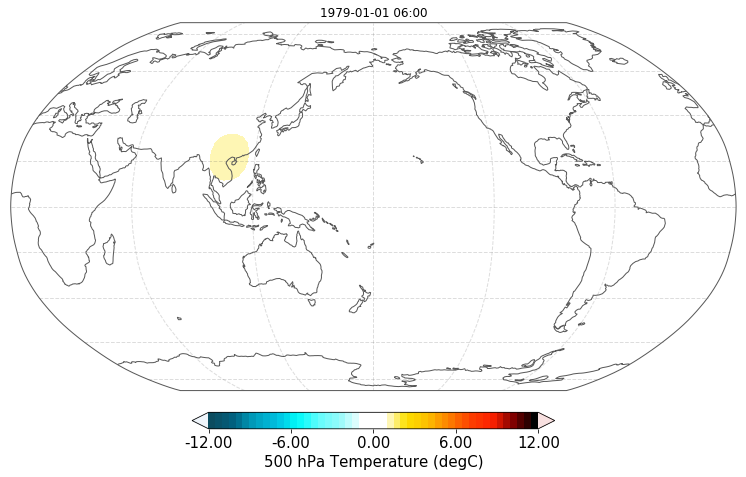

In [11]:
#----------------------------------------------------
#------ PLOT PARAMETERS------------------------------
#----------------------------------------------------

#------------ geography
# Global plot? True/False
glo= True

# center longitude on:
loncentr=180.

# set coastL to True if you want coaslines
coastL=True

#------------ color shading

# type of plot (can be 'contourf', 'pcolormesh', defaut is contourf)
typlo='contourf'

# min max values on the colorscale
vmin=-12
vmax=12

# colormap
cm_base=slx.make_NCLcolormap()

# number of color segments of the colormap
Nincr=50

# color of the values smaller than vmin
su='#EFF5FB'
# color of the values larger than vmax
so='#F8E0E0'

# colorbar label 
labelplt= "500 hPa Temperature ("+air.units+")"

# number of labels on the colorbar
Nbar=5

#------------ plot output
# plot format
pltty = ".png"

# plot resolution (dpi)
dpifig=200

# base name for output plot file
plti="T500_"+CONFIGNAME

# output directory for plots
diro="./"


#----------------------------------------------------
#------ LOOP ON TIMESTEP ----------------------------
#----------------------------------------------------

# loop on all time steps in the data array:
for it in range(0,air.time.size):
    
        # this is to plor only once a day (when hour==00)
        #if (time.hour[it]==0):
                
            # output plot file name including the time index
            plto = plti+"."+str(it+100)

            # data to plot (must be a 2-d np.array)
            # here we select one timestep at a time for plotting purposes
            data2plot  = air.isel(time=it).values

            # make the data to plot cyclic so that the values at longitude 0 are repeated at 360. (for plot purposes)
            cyclic_data, cyclic_lons = ccu.add_cyclic_point(data2plot, coord=air.lon.values)

            #----------------------------------------------------
            #------ PLOT ----------------------------------------
            #----------------------------------------------------

            # create fig
            fig1 = plt.figure(figsize=([13,10]),facecolor='white')

            # plot data (base plot from plotmap functionn defined above)
            cs = slx.plotmap(fig1,cyclic_data,cyclic_lons,air.lat.values,plto,cm_base=cm_base,vmin=vmin,vmax=vmax,Nincr=Nincr,glo=glo,coastL=coastL,su=su,so=so,loncentr=loncentr,typlo=typlo,Nbar=Nbar,labelplt=labelplt)

            # add title on plot (date)
            plt.title(slx.printdatestring(air.time.to_index(),it))

            if it==1:
                # display plot only once in the loop
                plt.show()

            # Save fig in png, resolution dpi
            fig1.savefig(diro+"/"+plto+'.png', facecolor=fig1.get_facecolor(), edgecolor='none',dpi=dpifig,bbox_inches='tight', pad_inches=0)#

            # close fig
            plt.close(fig1)       

=====================================================================================================

# - For an example with north pole stereographic projection, 
see the specific other notebook


=====================================================================================================
# - To make a movie from a set of png images:
* you need to install ffmpeg (on a mac you can install it via homebrew if you use homebrew). 

For example: 

```brew install ffmpeg --with-fdk-aac --with-ffplay --with-freetype --with-frei0r --with-libass --with-libvo-aacenc --with-libvorbis --with-libvpx --with-opencore-amr --with-openjpeg --with-opus --with-rtmpdump --with-schroedinger --with-speex --with-theora --with-tools ```

* Then get Laurent Brodeau's script  images2mp4.sh (which is based on ffmpeg):

```git clone  https://github.com/brodeau/climporn.git```

* Run Laurent's script in the directory where is stored your set of png images. For example:

```~/WORK/UTILS/climporn/ffmpeg/images2mp4.sh -i T500_history.air.500.model.4xdaily  -h 488 -f 30```

* To read the doc about the different options of this script, just run:

```~/WORK/UTILS/climporn/ffmpeg/images2mp4.sh```